In [8]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import sys

import torch

from time import time



from matplotlib          import rcParams, rc
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 10})
rc('font', family='serif')
rc('text', usetex=True)
# plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')

import src.mace.CSE_0D.dataset          as ds
import train                as train
import test                      as test
import src.mace.mace                    as mace
from loss               import Loss
import src.mace.utils                   as utils
# from src.mace.neuralODE    import Solver

def temp(Tstar, eps, r):
    Rstar = 2e13
    # r = 1e16
    T = Tstar * (r/Rstar)**(-eps)
    return T

specs_dict, idx_specs = utils.get_specs()

dt_fracts = {4 : 0.296, 5: 0.269,8: 0.221,10: 0.175,12: 0.146,16: 0.117,20: 0.09,25: 0.078,32: 0.062,48: 0.043,64: 0.033,128: 0.017}


%reload_ext autoreload
%autoreload 2

### Setup hyperparameters for mace model

In [20]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 

lr = 1.e-5
epochs = 2
batch_size = 1
nb_test = 300
n_dim = 468


losstype = 'abs_idn'
z_dim = 8
nb_samples = 100
nb_hidden = 1
ae_type = 'simple'


print('------------------------------')
print('      # epochs:', epochs)
print(' learning rate:', lr)
print('# z dimensions:', z_dim)
print('     # samples:', nb_samples)
print('     loss type:', losstype)
print('')


traindata, testdata, data_loader, test_loader = ds.get_data(dt_fract=dt_fracts[z_dim],nb_samples=nb_samples,nb_test = nb_test, batch_size=batch_size, kwargs=kwargs)

------------------------------
      # epochs: 2
 learning rate: 1e-05
# z dimensions: 8
     # samples: 100
     loss type: abs_idn

Dataset:
------------------------------
  total # of samples: 100
#   training samples: 70
# validation samples: 30
               ratio: 0.3
     #  test samples: 300


### Local MACE training


In [12]:
## Local model

model = mace.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim,nb_hidden=nb_hidden, ae_type=ae_type, DEVICE = DEVICE)

num_params = utils.count_parameters(model)
print(f'The model has {num_params} trainable parameters\n')


norm = {'abs' : 1,
        'grd' : 1,
        'idn' : 1}

fract = {'abs' : 1,
         'grd' : 1,
         'idn' : 1}

plot = False


## Make loss objects
trainloss = Loss(norm, fract, losstype)
testloss  = Loss(norm, fract, losstype)


tic = time()
opt = train.train(model, lr, data_loader, test_loader, nb_evol=0, path = None, end_epochs = epochs, DEVICE= DEVICE, trainloss=trainloss, testloss=testloss, start_time = time(), plot=plot)
toc = time()

print('Total time [s]:',toc-tic)




The model has 284692 trainable parameters

Model:         
learning rate: 1e-05
loss type:     abs_idn

Local training scheme in use.

>>> Training model...
Epoch 1 complete! 	Average loss train:  15.87214 	Average loss test:  6.67233
              time [hours]:  0.00205
Epoch 2 complete! 	Average loss train:  15.10458 	Average loss test:  6.25318
              time [hours]:  0.00382
Epoch 3 complete! 	Average loss train:  13.82499 	Average loss test:  5.56566
              time [hours]:  0.0055
Epoch 4 complete! 	Average loss train:  11.91193 	Average loss test:  4.63646
              time [hours]:  0.00739
Epoch 5 complete! 	Average loss train:  9.62745 	Average loss test:  3.64822
              time [hours]:  0.00911
Epoch 6 complete! 	Average loss train:  7.45978 	Average loss test:  2.80654
              time [hours]:  0.01109
Epoch 7 complete! 	Average loss train:  5.74288 	Average loss test:  2.20463
              time [hours]:  0.01279
Epoch 8 complete! 	Average loss train:  4.

In [13]:
trainloss.get_all_losses(), trainloss.get_losstype()


({'tot': array([0.52907147, 0.50348616, 0.46083285, 0.39706421, 0.32091484,
         0.24865944, 0.19142949, 0.15246815, 0.12535247, 0.10670872,
         0.09514268, 0.08757549, 0.08209496, 0.07777886, 0.07427633,
         0.07136916, 0.06892764, 0.06688936, 0.0651888 , 0.0637925 ]),
  'abs': array([0.26470621, 0.25189809, 0.23055571, 0.19865001, 0.16054253,
         0.12436309, 0.09569547, 0.07616504, 0.06256285, 0.05321502,
         0.04741432, 0.04362058, 0.04087737, 0.03871867, 0.03696992,
         0.03552082, 0.03431046, 0.03330433, 0.0324712 , 0.03178898]),
  'grd': array([0.00016017, 0.00015823, 0.00015365, 0.000151  , 0.00016104,
         0.00018975, 0.00023017, 0.0002744 , 0.00030864, 0.00033429,
         0.00035087, 0.00035738, 0.00035955, 0.00035555, 0.00034855,
         0.00033897, 0.0003291 , 0.00031507, 0.00030127, 0.00028688]),
  'idn': array([0.26420509, 0.25142984, 0.2301235 , 0.19826321, 0.16021127,
         0.12410659, 0.09550385, 0.07602872, 0.06248099, 0.0531594 ,


In [14]:
model.get_status('train')

array([9110., 9110., 9110., 9110., 9110., 9110., 9110., 9110., 9110.,
       9110., 9110., 9110., 9110., 9110., 9110., 9110., 9110., 9110.,
       9110., 9110.])

In [15]:
testpath = testdata.testpath[5]
# print(testpath)

# print('>> Loading test data...')
input_data, info = ds.get_test_data(testpath,testdata)

n, n_hat, dt, mace_time = test.test_step(model, input_data)
n_evol, mace_evol_time = test.test_evolution(model, input_data, start_idx=0)

plt.plot(n_hat)
plt.plot(input_data[0], 'k--', alpha = 0.2, lw = 0.5)


plt.show()

>>> Testing model...
Solving time [s]: 0.01052999496459961

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 170.79it/s]

Solving time [s]: 0.7743701934814453
Total   time [s]: 0.7871274948120117


### Integrated MACE training


The model has 284692 trainable parameters

Model:         
learning rate: 1e-05
loss type:     abs_idn

Integrated training scheme in use.

>>> Training model...
Epoch 1 complete! 	Average loss train:  16.04197 	Average loss test:  6.76193
              time [hours]:  0.00322
Epoch 2 complete! 	Average loss train:  15.40654 	Average loss test:  6.44752
              time [hours]:  0.00674

 	DONE!

 >>> Plotting...


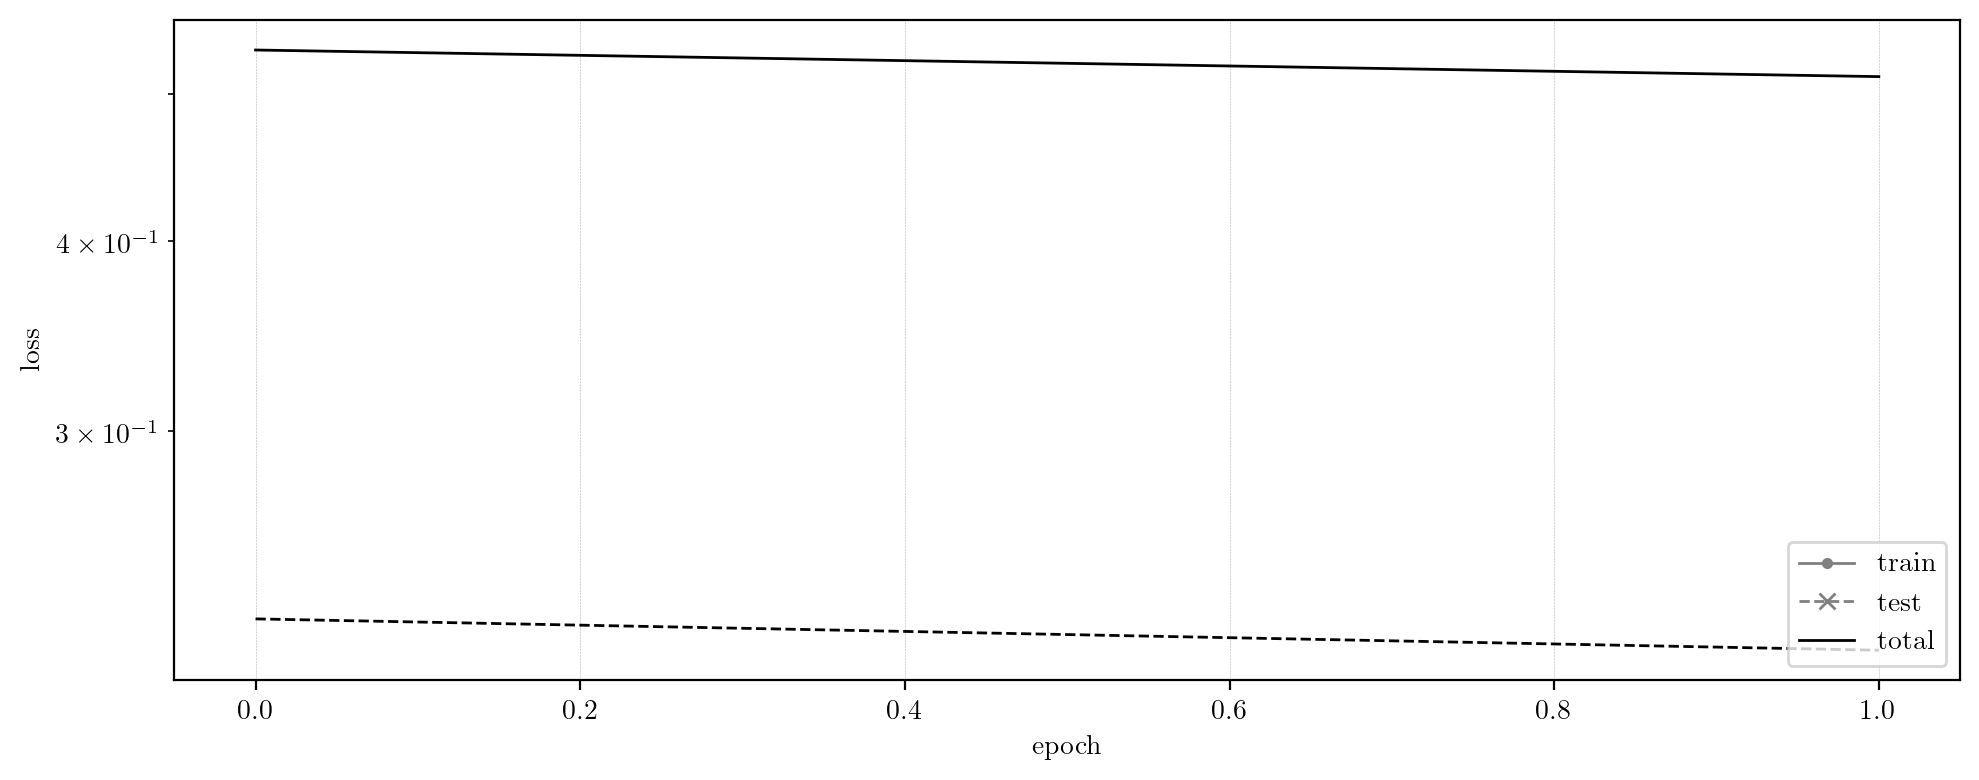

Total time [s]: 25.137871980667114


In [22]:
## Integrated model

model_integr = mace.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim,nb_hidden=nb_hidden, ae_type=ae_type, DEVICE = DEVICE)

num_params = utils.count_parameters(model)
print(f'The model has {num_params} trainable parameters\n')


norm = {'abs' : 1,
        'grd' : 1,
        'idn' : 1}

fract = {'abs' : 1,
         'grd' : 1,
         'idn' : 1}

plot = True
nb_evol = 8


## Make loss objects
trainloss_integr = Loss(norm, fract, losstype)
testloss_integr  = Loss(norm, fract, losstype)


tic = time()
opt = train.train(model_integr, lr, data_loader, test_loader, nb_evol=nb_evol, path = None, end_epochs = epochs, DEVICE= DEVICE, trainloss=trainloss_integr, testloss=testloss_integr, start_time = time(), plot=plot)
toc = time()

print('Total time [s]:',toc-tic)




>>> Testing model...
Solving time [s]: 0.009793996810913086

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 139.72it/s]


Solving time [s]: 0.9431271553039551
Total   time [s]: 0.961280107498169


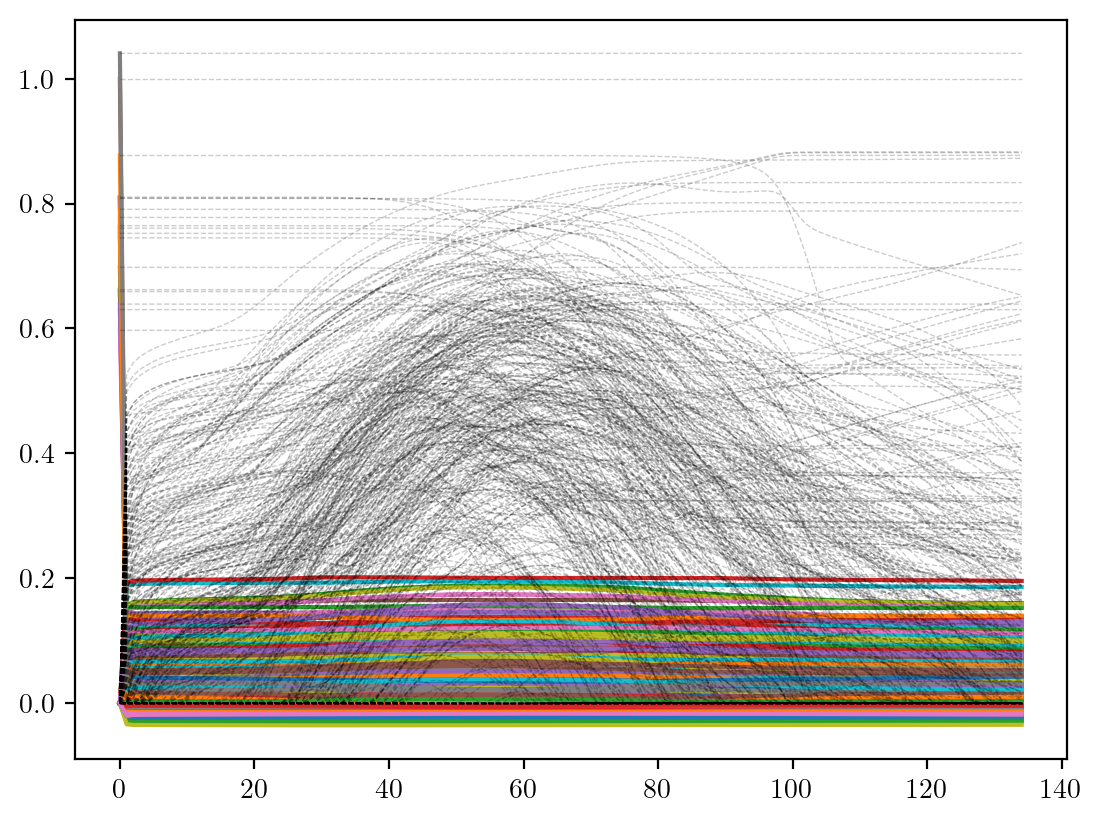

In [23]:
testpath = testdata.testpath[5]

model = model_integr

# print('>> Loading test data...')
input_data, info = ds.get_test_data(testpath,testdata)

n, n_hat, dt, mace_time = test.test_step(model, input_data)
n_evol, mace_evol_time = test.test_evolution(model, input_data, start_idx=0)

plt.plot(n_hat)
plt.plot(input_data[0], 'k--', alpha = 0.2, lw = 0.5)


plt.show()